In [16]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.optim as optim

****Dataset Class****

In [2]:
# =============================== DATASET CLASS ===============================
class ROIDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.tiff', '.tif', '.png', '.jpg'))])
        self.mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.tiff', '.tif', '.png', '.jpg'))])
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (mask > 0).float()
        return image, mask

In [2]:
class ROIDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.tiff', '.tif', '.png', '.jpg'))])
        self.mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.tiff', '.tif', '.png', '.jpg'))])
        # If no transform is provided, use an enhanced augmentation pipeline:
        if transform is None:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),           # horizontal flip
                transforms.RandomRotation(15),                 # random rotation up to 15 degrees
                transforms.ColorJitter(hue=0.05, saturation=0.05),  # slight color jitter
                transforms.GaussianBlur(kernel_size=3),        # Gaussian blur with kernel size 3
                transforms.ToTensor(),
                # Optionally add normalization here, e.g. transforms.Normalize(mean, std)
            ])
        else:
            self.transform = transform
        
        if mask_transform is None:
            self.mask_transform = transforms.Compose([
                transforms.ToTensor(),
            ])
        else:
            self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image = self.transform(image)
        mask = self.mask_transform(mask)

        # Ensure mask is binary
        mask = (mask > 0).float()
        return image, mask

In [3]:
def tta_predict(model, image, device):
    """
    Perform test-time augmentation by averaging predictions on original and horizontally flipped image.
    """
    model.eval()
    with torch.no_grad():
        # Original prediction
        image = image.to(device)
        pred_orig = model(image.unsqueeze(0))  # assume image is a tensor with shape C x H x W
        
        # Horizontal flip prediction
        image_flipped = torch.flip(image, dims=[2])  # flip along width dimension
        pred_flip = model(image_flipped.unsqueeze(0))
        # Flip back the prediction
        pred_flip = torch.flip(pred_flip, dims=[3])
        
        # Average predictions
        pred_avg = (pred_orig + pred_flip) / 2.0
        
    return pred_avg.squeeze(0)

In [4]:
def ensemble_predict(models, weights, image, device, use_tta=False):
    """
    Given a list of models and their corresponding weights, compute a weighted ensemble prediction.
    If use_tta is True, apply TTA to each model's prediction.
    """
    assert len(models) == len(weights), "Number of models and weights must match."
    ensemble_pred = 0
    total_weight = sum(weights)
    
    for model, weight in zip(models, weights):
        if use_tta:
            pred = tta_predict(model, image, device)
        else:
            model.eval()
            with torch.no_grad():
                pred = model(image.unsqueeze(0).to(device))
                pred = pred.squeeze(0)
        ensemble_pred += weight * pred
    
    ensemble_pred /= total_weight
    return ensemble_pred

****Baseline Models****

In [5]:
# =============================== BASELINE MODELS ===============================

# 1. Standard UNet
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.dec4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.dec3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upconv1(dec2), enc1), dim=1))
        
        return torch.sigmoid(self.conv_last(dec1))

# 2. ResUNet - Basic Residual Block
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicResidualBlock, self).__init__()
        
        self.residual_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        # Identity mapping
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.residual_path(x)
        shortcut = self.shortcut(x)
        return F.relu(residual + shortcut, inplace=True)

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Encoder
        self.enc1 = BasicResidualBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = BasicResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = BasicResidualBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = BasicResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = BasicResidualBlock(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = BasicResidualBlock(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = BasicResidualBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = BasicResidualBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = BasicResidualBlock(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.dec4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.dec3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upconv1(dec2), enc1), dim=1))
        
        return torch.sigmoid(self.conv_last(dec1))

# 3. UNet with VGG16 backbone
class UNetVGG16(nn.Module):
    def __init__(self, out_channels=1, pretrained=True):
        super(UNetVGG16, self).__init__()
        
        # Load pretrained VGG16
        vgg16 = models.vgg16(pretrained=pretrained)
        vgg16_features = vgg16.features
        
        # Encoder (VGG16 features)
        self.enc1 = vgg16_features[:4]    # 64 channels
        self.enc2 = vgg16_features[4:9]   # 128 channels
        self.enc3 = vgg16_features[9:16]  # 256 channels
        self.enc4 = vgg16_features[16:23] # 512 channels
        self.enc5 = vgg16_features[23:30] # 512 channels
        
        # Decoder
        self.upconv5 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec5 = self._make_decoder_block(1024, 512)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = self._make_decoder_block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self._make_decoder_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self._make_decoder_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        
        # Decoder path with skip connections
        dec5 = self.dec5(torch.cat([self.upconv5(enc5), enc4], dim=1))
        dec4 = self.dec4(torch.cat([self.upconv4(dec5), enc3], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc2], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc1], dim=1))
        
        return torch.sigmoid(self.conv_last(dec2))

# 4. Double UNet
class DoubleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(DoubleUNet, self).__init__()
        
        # First UNet
        self.unet1 = UNet(in_channels, out_channels)
        
        # Second UNet
        self.unet2 = UNet(in_channels + out_channels, out_channels)
        
    def forward(self, x):
        # First UNet
        output1 = self.unet1(x)
        
        # Second UNet with concatenated input
        concat_input = torch.cat([x, output1], dim=1)
        output2 = self.unet2(concat_input)
        
        return output2

****SegRExt-A****

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # Identity mapping for different dimensions
        self.identity_mapping = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        identity = self.identity_mapping(x)
        return identity + self.conv_block(x)

In [7]:
class SegRExt_A(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegRExt_A, self).__init__()
        
        # Load pretrained ResNet50 as encoder backbone
        resnet = models.resnet50(pretrained=True)
        
        # Encoder blocks (using ResNet layers)
        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )  # Expected output: 64 channels, spatial size ~128x128 for 512x512 input
        self.encoder2 = resnet.layer1  # 256 channels, 128x128
        self.encoder3 = resnet.layer2  # 512 channels, 64x64
        self.encoder4 = resnet.layer3  # 1024 channels, 32x32
        self.encoder5 = resnet.layer4  # 2048 channels, 16x16
        
        # Decoder blocks with residual units
        # Decoder block 1
        self.upconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock(2048, 1024)  # Concatenate with e4 (1024 channels)
        
        # Decoder block 2
        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock(1024, 512)  # Concatenate with e3 (512 channels)
        
        # Decoder block 3
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock(512, 256)  # Concatenate with e2 (256 channels)
        
        # Decoder block 4
        self.upconv4 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock(128, 64)  # Concatenate with e1 (64 channels)
        
        # Final output layer
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)  # (B, 64, 128, 128)
        e2 = self.encoder2(e1)  # (B, 256, 128, 128)
        e3 = self.encoder3(e2)  # (B, 512, 64, 64)
        e4 = self.encoder4(e3)  # (B, 1024, 32, 32)
        e5 = self.encoder5(e4)  # (B, 2048, 16, 16)
        
        # Decoder path
        d1 = self.upconv1(e5)           # (B, 1024, 32, 32)
        d1 = torch.cat([d1, e4], dim=1)   # (B, 2048, 32, 32)
        d1 = self.decoder1(d1)           # (B, 1024, 32, 32)
        
        d2 = self.upconv2(d1)           # (B, 512, 64, 64)
        d2 = torch.cat([d2, e3], dim=1)   # (B, 1024, 64, 64)
        d2 = self.decoder2(d2)           # (B, 512, 64, 64)
        
        d3 = self.upconv3(d2)           # (B, 256, 128, 128)
        d3 = torch.cat([d3, e2], dim=1)   # (B, 512, 128, 128)
        d3 = self.decoder3(d3)           # (B, 256, 128, 128)
        
        d4 = self.upconv4(d3)           # (B, 64, 256, 256)
        # Upsample e1 to match d4's spatial dimensions (256x256)
        e1_upsampled = F.interpolate(e1, size=d4.shape[2:], mode="bilinear", align_corners=True)
        d4 = torch.cat([d4, e1_upsampled], dim=1)  # (B, 64+64=128, 256, 256)
        d4 = self.decoder4(d4)          # (B, 64, 256, 256)
        
        output = torch.sigmoid(self.conv_last(d4))  # (B, 1, 256, 256)
        # Upsample final output to match input size (512x512)
        output = F.interpolate(output, size=x.shape[2:], mode="bilinear", align_corners=True)
        return output


****SegRExt-F****

In [8]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

# CBAM Module (Convolutional Block Attention Module)
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_att = SpatialAttention(kernel_size)
    
    def forward(self, x):
        x = x * self.channel_att(x)  # Apply channel attention
        x = x * self.spatial_att(x)  # Apply spatial attention
        return x

# Squeeze and Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Improved Residual Block with SE
class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedResidualBlock, self).__init__()
        
        # Main path
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        # Identity mapping with SE
        self.identity_mapping = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            SEBlock(out_channels)
        ) if in_channels != out_channels else SEBlock(in_channels)
    
    def forward(self, x):
        identity = self.identity_mapping(x)
        main = self.main_path(x)
        return F.relu(identity + main, inplace=True)

In [9]:
class SegRExt_F(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegRExt_F, self).__init__()
        
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        features = mobilenet.features
        
        self.enc1 = features[0:3]    # Expected output: 24 channels
        self.enc2 = features[3:6]    # Expected output: 40 channels
        self.enc3 = features[6:9]    # Expected output: 80 channels
        self.enc4 = features[9:12]   # Expected output: 112 channels
        self.enc5 = features[12:16]  # Expected output: 160 channels
        
        self.cbam1 = CBAM(24)
        self.cbam2 = CBAM(40)
        self.cbam3 = CBAM(80)
        self.cbam4 = CBAM(112)
        
        # Decoder blocks with improved residual units
        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = ImprovedResidualBlock(160 + 112, 112)  # 160 from e5 upsampled and 112 from e4_att
        
        self.upconv2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = ImprovedResidualBlock(112 + 80, 80)    # 112 from d1 and 80 from e3_att
        
        self.upconv3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = ImprovedResidualBlock(80 + 40, 40)     # 80 from d2 and 40 from e2_att
        
        self.upconv4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = ImprovedResidualBlock(40 + 24, 24)     # 40 from d3 and 24 from e1_att
        
        self.final_upconv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_last = nn.Conv2d(24, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        
        # Apply CBAM to skip connections
        e1_att = self.cbam1(e1)
        e2_att = self.cbam2(e2)
        e3_att = self.cbam3(e3)
        e4_att = self.cbam4(e4)
        
        # Decoder block 1
        d1 = self.upconv1(e5)
        e4_att_up = F.interpolate(e4_att, size=d1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e4_att_up], dim=1)
        d1 = self.dec1(d1)
        
        # Decoder block 2
        d2 = self.upconv2(d1)
        e3_att_up = F.interpolate(e3_att, size=d2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e3_att_up], dim=1)
        d2 = self.dec2(d2)
        
        # Decoder block 3
        d3 = self.upconv3(d2)
        e2_att_up = F.interpolate(e2_att, size=d3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e2_att_up], dim=1)
        d3 = self.dec3(d3)
        
        # Decoder block 4
        d4 = self.upconv4(d3)
        e1_att_up = F.interpolate(e1_att, size=d4.shape[2:], mode='bilinear', align_corners=True)
        d4 = torch.cat([d4, e1_att_up], dim=1)
        d4 = self.dec4(d4)
        
        d5 = self.final_upconv(d4)
        output = torch.sigmoid(self.conv_last(d5))
        
        return output


****Loss Functions****

In [10]:
# =============================== LOSS FUNCTIONS ===============================

# Binary Cross Entropy Loss
def bce_loss(pred, target):
    return F.binary_cross_entropy(pred, target)

# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

# Combined BCE and Dice Loss
def combo_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

# Enhanced Matching Loss
def em_loss(pred, target, smooth=1e-6):
    # Alignment matrix creation
    # Simplified implementation
    b, c, h, w = pred.size()
    n_pixels = h * w
    
    pred_flat = pred.view(b, -1)
    target_flat = target.view(b, -1)
    
    alignment = 1 - torch.abs(pred_flat - target_flat)
    alignment_sum = torch.sum(alignment, dim=1) / n_pixels
    
    return 1 - torch.mean(alignment_sum)

****Metrics****

In [11]:
# =============================== METRICS ===============================

class SegmentationMetrics:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0
        self.total_time = 0
        self.count = 0
    
    def update(self, preds, targets, time_taken=0):
        # Convert to binary using threshold
        preds = (preds > 0.5).float()
        
        self.tp += torch.sum((preds == 1) & (targets == 1)).item()
        self.fp += torch.sum((preds == 1) & (targets == 0)).item()
        self.tn += torch.sum((preds == 0) & (targets == 0)).item()
        self.fn += torch.sum((preds == 0) & (targets == 1)).item()
        self.total_time += time_taken
        self.count += targets.size(0)
    
    def get_metrics(self):
        # Jaccard Index (IoU)
        jcc = self.tp / (self.tp + self.fp + self.fn + 1e-10)
        
        # Dice Similarity Coefficient
        dsc = (2 * self.tp) / (2 * self.tp + self.fp + self.fn + 1e-10)
        
        # Precision
        precision = self.tp / (self.tp + self.fp + 1e-10)
        
        # Recall
        recall = self.tp / (self.tp + self.fn + 1e-10)
        
        # Accuracy
        accuracy = (self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn + 1e-10)
        
        # Frames Per Second
        fps = self.count / (self.total_time + 1e-10) if self.total_time > 0 else 0
        
        return {
            "Jcc": jcc,
            "DSC": dsc,
            "Pr": precision,
            "Re": recall,
            "Acc": accuracy,
            "FPS": fps
        }

****Training****

In [10]:
# =============================== TRAINING AND EVALUATION ===============================

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device, metrics=None):
    model.eval()
    total_loss = 0.0
    
    if metrics is not None:
        metrics.reset()
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time
            
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            if metrics is not None:
                metrics.update(outputs, masks, inference_time)
    
    return total_loss / len(dataloader)


In [12]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [13]:
def evaluate_model(model, dataloader, criterion, device, metrics=None, use_tta=False):
    model.eval()
    total_loss = 0.0
    
    if metrics is not None:
        metrics.reset()
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            start_time = time.time()
            if use_tta:
                # Apply TTA for each image in the batch
                outputs = torch.stack([tta_predict(model, img, device) for img in images])
            else:
                outputs = model(images)
            inference_time = time.time() - start_time
            
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            if metrics is not None:
                metrics.update(outputs, masks, inference_time)
    
    return total_loss / len(dataloader)

****Main****

In [18]:
def main():
    # Data paths
    train_images_dir = '/kaggle/input/massachusetts-roads-dataset/tiff/train'
    train_masks_dir = '/kaggle/input/massachusetts-roads-dataset/tiff/train_labels'
    val_images_dir = '/kaggle/input/massachusetts-roads-dataset/tiff/val'
    val_masks_dir = '/kaggle/input/massachusetts-roads-dataset/tiff/val_labels'
    test_images_dir = '/kaggle/input/massachusetts-roads-dataset/tiff/test'
    test_masks_dir = '/kaggle/input/massachusetts-roads-dataset/tiff/test_labels'
    
    target_size = (512, 512)
    
    # Data transformations
    image_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    mask_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    # Create datasets
    train_dataset = ROIDataset(train_images_dir, train_masks_dir, image_transforms, mask_transforms)
    val_dataset = ROIDataset(val_images_dir, val_masks_dir, image_transforms, mask_transforms)
    test_dataset = ROIDataset(test_images_dir, test_masks_dir, image_transforms, mask_transforms)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

    # Device configuration and multi-GPU support
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_gpus = torch.cuda.device_count()
    print(f"Using device: {device} with {num_gpus} GPU(s)")

    # Dictionary to track all models
    models_dict = {
        #'UNet': UNet(),
        #'ResUNet': ResUNet(),
        #'UNetVGG16': UNetVGG16(),
        #'DoubleUNet': DoubleUNet(),
        'SegRExt_A': SegRExt_A(),
        'SegRExt_F': SegRExt_F()
    }
    
    # Training parameters
    num_epochs = 25
    learning_rate = 1e-4
    criterion = combo_loss  # Combined BCE and Dice loss
    
    # Results storage
    results = {}
    
    # Train and evaluate each model
    for model_name, model in models_dict.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")
        
        model = model.to(device)
        # If multiple GPUs are available, wrap the model with DataParallel.
        if torch.cuda.device_count() > 1:
            model = torch.nn.DataParallel(model)
        
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        best_val_loss = float('inf')
        no_improve_epochs = 0  # counter for early stopping
        
        # Metrics tracker
        metrics = SegmentationMetrics()
        
        # Training loop with early stopping (patience=5)
        for epoch in range(num_epochs):
            train_loss = train_model(model, train_loader, optimizer, criterion, device)
            val_loss = evaluate_model(model, val_loader, criterion, device)
            print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_epochs = 0
                torch.save(model.state_dict(), f'best_{model_name}.pth')
                print(f"Model saved as best_{model_name}.pth")
            else:
                no_improve_epochs += 1
                print(f"No improvement for {no_improve_epochs} consecutive epochs.")
                if no_improve_epochs >= 5:
                    print("Early stopping triggered.")
                    break
        
        # Load best model for evaluation
        model.load_state_dict(torch.load(f'best_{model_name}.pth', map_location=device))
        
        # Evaluate on test set and calculate metrics
        test_loss = evaluate_model(model, test_loader, criterion, device, metrics)
        test_metrics = metrics.get_metrics()
        
        print(f"\nTest Results for {model_name}:")
        print(f"Test Loss: {test_loss:.4f}")
        for metric_name, metric_value in test_metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")
        
        # Store results
        results[model_name] = {
            'test_loss': test_loss,
            'metrics': test_metrics
        }
    
    # Print comparison table
    print("\n" + "="*80)
    print("Model Comparison")
    print("="*80)
    print(f"{'Model':<15} {'Jcc':<10} {'DSC':<10} {'Pr':<10} {'Re':<10} {'Acc':<10} {'FPS':<10}")
    print("-"*80)
    
    for model_name, result in results.items():
        metrics = result['metrics']
        print(f"{model_name:<15} "
              f"{metrics['Jcc']:<10.4f} "
              f"{metrics['DSC']:<10.4f} "
              f"{metrics['Pr']:<10.4f} "
              f"{metrics['Re']:<10.4f} "
              f"{metrics['Acc']:<10.4f} "
              f"{metrics['FPS']:<10.4f}")

if __name__ == '__main__':
    main()


Using device: cuda with 2 GPU(s)

Training SegRExt_A
Epoch 1/25: Train Loss=0.7383, Val Loss=0.5937
Model saved as best_SegRExt_A.pth
Epoch 2/25: Train Loss=0.5921, Val Loss=0.5492
Model saved as best_SegRExt_A.pth
Epoch 3/25: Train Loss=0.5664, Val Loss=0.5109
Model saved as best_SegRExt_A.pth
Epoch 4/25: Train Loss=0.5430, Val Loss=0.4931
Model saved as best_SegRExt_A.pth
Epoch 5/25: Train Loss=0.5174, Val Loss=0.4813
Model saved as best_SegRExt_A.pth
Epoch 6/25: Train Loss=0.4938, Val Loss=0.4793
Model saved as best_SegRExt_A.pth
Epoch 7/25: Train Loss=0.4896, Val Loss=0.4794
No improvement for 1 consecutive epochs.
Epoch 8/25: Train Loss=0.4620, Val Loss=0.4903
No improvement for 2 consecutive epochs.
Epoch 9/25: Train Loss=0.4366, Val Loss=0.4941
No improvement for 3 consecutive epochs.
Epoch 10/25: Train Loss=0.4807, Val Loss=0.5005
No improvement for 4 consecutive epochs.
Epoch 11/25: Train Loss=0.4417, Val Loss=0.4864
No improvement for 5 consecutive epochs.
Early stopping trig

<ipython-input-18-44c77e1520d1>:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name}.pth', map_location=device))



Test Results for SegRExt_A:
Test Loss: 0.4132
Jcc: 0.6302
DSC: 0.7732
Pr: 0.7728
Re: 0.7735
Acc: 0.9607
FPS: 31.5775

Training SegRExt_F
Epoch 1/25: Train Loss=1.2463, Val Loss=1.1075
Model saved as best_SegRExt_F.pth
Epoch 2/25: Train Loss=1.0772, Val Loss=0.9700
Model saved as best_SegRExt_F.pth
Epoch 3/25: Train Loss=0.9644, Val Loss=0.9112
Model saved as best_SegRExt_F.pth
Epoch 4/25: Train Loss=0.8761, Val Loss=0.7964
Model saved as best_SegRExt_F.pth
Epoch 5/25: Train Loss=0.8024, Val Loss=0.7400
Model saved as best_SegRExt_F.pth
Epoch 6/25: Train Loss=0.7428, Val Loss=0.7113
Model saved as best_SegRExt_F.pth
Epoch 7/25: Train Loss=0.7019, Val Loss=0.6632
Model saved as best_SegRExt_F.pth
Epoch 8/25: Train Loss=0.6681, Val Loss=0.6353
Model saved as best_SegRExt_F.pth
Epoch 9/25: Train Loss=0.6405, Val Loss=0.6308
Model saved as best_SegRExt_F.pth
Epoch 10/25: Train Loss=0.6187, Val Loss=0.6034
Model saved as best_SegRExt_F.pth
Epoch 11/25: Train Loss=0.6049, Val Loss=0.5933
Mod

****Output Production****

In [19]:
import os
import time
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from collections import OrderedDict

def generate_roi_outputs(model_path, model_class, input_folder, output_folder, device='cuda'):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Load the segmentation model
    model = model_class().to(device)
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    # Remove "module." prefix if present
    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        new_key = k.replace("module.", "")  # strip the prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.eval()
    
    # Define the image transformation (must match training preprocessing)
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png','.jpg','.jpeg','.tiff','.tif')):
            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path).convert('RGB')
            original_np = np.array(image)  # Keep the original for cropping
            
            # Preprocess and run inference
            input_tensor = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
            # Get binary mask (values 0 or 1) and convert to uint8 (0-255)
            binary_mask = (output > 0.5).float().cpu().numpy()[0, 0]
            mask_img = (binary_mask * 255).astype(np.uint8)
            
            # Save the raw mask image
            mask_save_path = os.path.join(output_folder, f"mask_{filename}")
            Image.fromarray(mask_img).save(mask_save_path)
            
            # Use OpenCV to find the largest contour (RoI)
            contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                # Crop the original image to the RoI bounding box
                roi = original_np[y:y+h, x:x+w]
            else:
                roi = original_np  # Fallback to full image if no contour is found
            
            # Save the RoI output
            roi_save_path = os.path.join(output_folder, f"roi_{filename}")
            Image.fromarray(roi).save(roi_save_path)
            
            print(f"Processed {filename}: Saved mask and ROI.")

if __name__ == '__main__':
    generate_roi_outputs(
         model_path='best_SegRExt_A.pth',  # or 'best_SegRExt_F.pth' depending on which you want to use
         model_class=SegRExt_A,             # Change to SegRExt_F if desired
         input_folder='/kaggle/input/massachusetts-roads-dataset/tiff/train',
         output_folder='/kaggle/working/roi_outputs',
         device='cuda' if torch.cuda.is_available() else 'cpu'
    )


<ipython-input-19-2d87373fde8b>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Processed 17428735_15.tiff: Saved mask and ROI.
Processed 23578780_15.tiff: Saved mask and ROI.
Processed 24178540_15.tiff: Saved mask and ROI.
Processed 12178705_15.tiff: Saved mask and ROI.
Processed 23278960_15.tiff: Saved mask and ROI.
Processed 20278930_15.tiff: Saved mask and ROI.
Processed 20578900_15.tiff: Saved mask and ROI.
Processed 12628810_15.tiff: Saved mask and ROI.
Processed 22528990_15.tiff: Saved mask and ROI.
Processed 21629065_15.tiff: Saved mask and ROI.
Processed 20578885_15.tiff: Saved mask and ROI.
Processed 19528630_15.tiff: Saved mask and ROI.
Processed 24329260_15.tiff: Saved mask and ROI.
Processed 15628885_15.tiff: Saved mask and ROI.
Processed 18328750_15.tiff: Saved mask and ROI.
Processed 21328915_15.tiff: Saved mask and ROI.
Processed 11428840_15.tiff: Saved mask and ROI.
Processed 23728945_15.tiff: Saved mask and ROI.
Processed 22079005_15.tiff: Saved mask and ROI.
Processed 15628930_15.tiff: Saved mask and ROI.
Processed 21479005_15.tiff: Saved mask a

In [16]:
import shutil

shutil.make_archive("roi_outputs_SegRExt-A", "zip", "roi_outputs")

'/kaggle/working/roi_outputs_SegRExt-A.zip'

****Inference****

<ipython-input-20-f0033188bd6a>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Inference time: 0.0123 seconds
FPS: 80.98


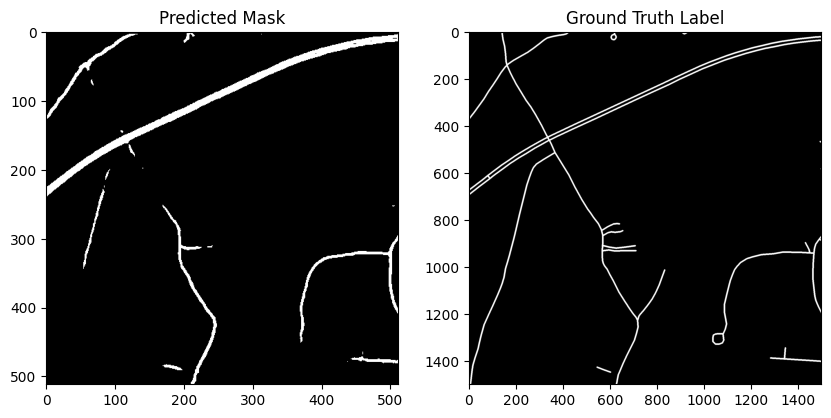

In [20]:
import os
import time
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

def inference_demo(model_path, model_class, image_path, device='cuda'):
    # Load model
    model = model_class().to(device)
    
    # Load checkpoint and strip "module." prefix if present
    checkpoint = torch.load(model_path, map_location=device)
    new_state_dict = OrderedDict()
    for key, value in checkpoint.items():
        new_key = key.replace("module.", "")  # remove the prefix
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()
    
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Run inference and measure time
    start_time = time.time()
    with torch.no_grad():
        output = model(input_tensor)
    inference_time = time.time() - start_time
    
    # Convert output to binary mask
    binary_mask = (output > 0.5).float().cpu().numpy()[0, 0]
    
    # Print inference time and FPS
    print(f"Inference time: {inference_time:.4f} seconds")
    print(f"FPS: {1/inference_time:.2f}")
    
    return binary_mask

# Example usage in main:
def main():
    model_path = "/kaggle/working/best_SegRExt_F.pth"  # Update with your model path
    image_path = "/kaggle/input/massachusetts-roads-dataset/tiff/test/10378780_15.tiff"  # Update with your image path
    label_path = "/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/10378780_15.tif"  # Update with your label path
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Run inference
    binary_mask = inference_demo(model_path, SegRExt_F, image_path, device)
    
    # Load ground truth label
    label = Image.open(label_path)
    label_array = np.array(label)
    
    # Display results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(binary_mask, cmap='gray')
    ax[0].set_title("Predicted Mask")
    ax[1].imshow(label_array, cmap='gray')
    ax[1].set_title("Ground Truth Label")
    plt.show()

if __name__ == "__main__":
    main()


****New****